In [1]:
# Import necessary libraries
import sys
sys.path.extend(["../../../"])
from src.para_voro import *
from src.para_voro_plots import *

np.random.seed(0)

In [2]:
import time

def runtime_experiments(dim: int, n_samples: int, n_samples_per_dim = 30, repeat: int = 10) -> tuple:
    timings_vor = []
    timings_ridges_and_clipping = []
    timings_sens_matrix = []

    for _ in range(repeat):
        np.random.seed(0)

        df = pd.DataFrame(data=np.random.random((n_samples, dim)))
        # remove the "Iris-" from class
        df = df.assign(**{"class": pd.Series([f"{v}" for v in (np.random.random((n_samples, )) > 0.5).astype(int)]).values})

        normalize_samples = True

        discrete_values_mapping = create_discrete_values_mapping(df)

        discrete_dims = {
            dim: col_name
            for dim, col_name in enumerate(df.columns[:-1]) if df[col_name].dtype == object
        }

        labels_names = df.values[:, -1]

        df_ = apply_discrete_values_mapping(df[df.columns[:-1]], discrete_values_mapping)

        samples = df_.values
        dim_labels = df_.columns.to_list()

        label_names, uq_idx, l_inv = np.unique(labels_names, return_index=True, return_inverse=True)
        labels = l_inv  # the label we use for computations are integers, while the label names may be strings / ints, floats / objects

        dim_colors = np.array(plt.color_sequences.get("Accent"))[:len(dim_labels)]

        if normalize_samples:
            # normalize samples  # TODO: should rather be [-0.5, 0.5] than [0.0., 1.0]
            mins = np.min(samples, 0)
            maxs = np.max(samples, 0)

            samples = (samples - mins) / (maxs - mins)

        # create discrete_dimension_ticks_and_labels mapping
        discrete_dimension_ticks_and_labels = {}
        for dim in discrete_dims:
            col_name = discrete_dims[dim]

            m = discrete_values_mapping[col_name]
            reverse_mapping = {v: k for k, v in m.items()}

            tick_values = np.linspace(0, 1.0 if normalize_samples else len(m) - 1, len(m))
            tick_labels = [reverse_mapping[idx] for idx in range(len(m))]

            discrete_dimension_ticks_and_labels[dim] = (tick_values, tick_labels)

        t = time.time()
        vor = Voronoi(samples)
        timings_vor.append(time.time() - t)

        aabbox = np.vstack([np.min(samples, 0), np.max(samples, 0)]).T

        t = time.time()
        generate_geometric_segment_boundaries_via_voronoi_result = generate_geometric_segment_boundaries_via_voronoi(samples, labels, aabbox, clip_convex_hull=True, vor=vor, return_original_ridge_point_indices=True, verbose=False)
        ridge_vertices, ridge_point_indices = generate_geometric_segment_boundaries_via_voronoi_result

        M_T = build_directed_ridge_vertices_selector_matrix(samples, labels, ridge_point_indices)

        timings_ridges_and_clipping.append(time.time() - t)

        t = time.time()

        step_size = None  # if none, it will be set equal to bandwidth (--> non-overlapping bins)
        bandwidths = (aabbox[:, 1] - aabbox[:, 0]) / n_samples_per_dim
        sample_points_min_max = compute_sample_points(clip_box=aabbox, bandwidths=bandwidths, step_size=step_size)

        n_proc = None  # single-core

        ridge_based_para_sense_preparations_result = ridge_based_para_sense_preparations(ridge_vertices=ridge_vertices,
                                                                                             bandwidths=bandwidths,
                                                                                             clip_box=aabbox,
                                                                                             step_size=step_size,
                                                                                             sample_points_min_max=sample_points_min_max,
                                                                                             verbose=False)
        build_directed_transition_cubes_result = build_directed_transition_cubes(M_T, ridge_vertices, sample_points_min_max=sample_points_min_max, 
                                                         ridge_based_para_sense_preparations_result=ridge_based_para_sense_preparations_result,
                                                         bandwidths=bandwidths, clip_box=aabbox, step_size=step_size, n_proc=n_proc, verbose=False)

        _, dtc_ret = build_directed_transition_cubes_result
        sens_matrix_list = [d[0] for d in dtc_ret]
        n_ridge_matrix_list = [d[1] for d in dtc_ret]

        timings_sens_matrix.append(time.time() - t)
    
    for s, t in zip(["vor", "ridge", "sens"], [timings_vor, timings_ridges_and_clipping, timings_sens_matrix]):
        print(f"dim: {dim}, n_samples: {n_samples}, repeat: {repeat}; type: {s}, average: {np.average(t)}, std: {np.std(t)}, median: {np.median(t)}")
    
    return np.stack([timings_vor, timings_ridges_and_clipping, timings_sens_matrix]).T
    


In [3]:
_ = runtime_experiments(3, 32, repeat=2)

c:\Users\bauerrn\Projekte\VoroParaSense\examples\notebooks\plot_examples\../../..\src\para_voro.py:295: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  d_ = point @ eq[:-1] + eq[-1]
c:\Users\bauerrn\Projekte\VoroParaSense\examples\notebooks\plot_examples\../../..\src\para_voro.py:334: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  d = np.dot(points[i], ridge_halfspace_definition[:-1]) + ridge_halfspace_definition[-1]


dim: 3, n_samples: 32, repeat: 2; type: vor, average: 0.0014865398406982422, std: 0.00048542022705078125, median: 0.0014865398406982422
dim: 3, n_samples: 32, repeat: 2; type: ridge, average: 4.191247940063477, std: 4.155245065689087, median: 4.191247940063477
dim: 3, n_samples: 32, repeat: 2; type: sens, average: 7.011904716491699, std: 4.0667901039123535, median: 7.011904716491699


In [16]:
# bandwidth experiment
res = []

for dims in [2, 3, 4]: # , 5, 6, 7, 8]:
    for n_samples in [64, 256, 1048, 4096]:
        res_ = runtime_experiments(dims, n_samples, repeat=3)
        res.append((dims, n_samples, res_))

dim: 2, n_samples: 64, repeat: 3; type: vor, average: 0.0010013580322265625, std: 3.573628609326222e-06, median: 0.00099945068359375
dim: 2, n_samples: 64, repeat: 3; type: ridge, average: 0.028992970784505207, std: 0.0024595432903155943, median: 0.029003381729125977
dim: 2, n_samples: 64, repeat: 3; type: sens, average: 0.028992970784505207, std: 0.0024595432903155943, median: 0.029003381729125977
dim: 2, n_samples: 256, repeat: 3; type: vor, average: 0.002341190973917643, std: 0.00048171041991494623, median: 0.0020008087158203125
dim: 2, n_samples: 256, repeat: 3; type: ridge, average: 0.06731327374776204, std: 0.00048362495560078534, median: 0.06697368621826172
dim: 2, n_samples: 256, repeat: 3; type: sens, average: 0.06731327374776204, std: 0.00048362495560078534, median: 0.06697368621826172
dim: 2, n_samples: 1048, repeat: 3; type: vor, average: 0.006644090016682942, std: 0.00048109593882211327, median: 0.006974935531616211
dim: 2, n_samples: 1048, repeat: 3; type: ridge, average:

TypeError: remove: path should be string, bytes or os.PathLike, not NoneType

Exception ignored in: 'scipy._lib.messagestream.MessageStream.__dealloc__'
Traceback (most recent call last):
  File "messagestream.pyx", line 91, in scipy._lib.messagestream.MessageStream.close
TypeError: remove: path should be string, bytes or os.PathLike, not NoneType


KeyboardInterrupt: 

In [20]:
# samples experiment for dim = 4
res2 = []

for dims in [4]:
    for n_samples in [128, 256, 512, 1024, 2048, 4096]:
        res_ = runtime_experiments(dims, n_samples, repeat=3)
        res2.append((dims, n_samples, res_))

dim: 4, n_samples: 128, repeat: 3; type: vor, average: 0.017665783564249676, std: 0.0020563065326819996, median: 0.018001556396484375
dim: 4, n_samples: 128, repeat: 3; type: ridge, average: 0.6659837563832601, std: 0.018280624705834136, median: 0.6685163974761963
dim: 4, n_samples: 128, repeat: 3; type: sens, average: 50.84448719024658, std: 2.723452833309136, median: 51.96826958656311
dim: 4, n_samples: 256, repeat: 3; type: vor, average: 0.03474203745524088, std: 0.0010518751268548138, median: 0.03400087356567383
dim: 4, n_samples: 256, repeat: 3; type: ridge, average: 1.5819531281789143, std: 0.1113786185576913, median: 1.6508851051330566
dim: 4, n_samples: 256, repeat: 3; type: sens, average: 98.2748195330302, std: 4.437020699769642, median: 95.57184195518494
dim: 4, n_samples: 512, repeat: 3; type: vor, average: 0.08153661092122395, std: 0.01149912282278886, median: 0.08499908447265625
dim: 4, n_samples: 512, repeat: 3; type: ridge, average: 3.8305466175079346, std: 0.37126440631

In [4]:
# dims experiment
res_3 = []

for dims in [2, 3, 4, 5, 6]:
    for n_samples in [50]:
        res_ = runtime_experiments(dims, n_samples, n_samples_per_dim=10, repeat=1)
        res_3.append((dims, n_samples, res_))

dim: 2, n_samples: 50, repeat: 1; type: vor, average: 0.001004934310913086, std: 0.0, median: 0.001004934310913086
dim: 2, n_samples: 50, repeat: 1; type: ridge, average: 0.017889976501464844, std: 0.0, median: 0.017889976501464844
dim: 2, n_samples: 50, repeat: 1; type: sens, average: 0.005998849868774414, std: 0.0, median: 0.005998849868774414
dim: 3, n_samples: 50, repeat: 1; type: vor, average: 0.0020074844360351562, std: 0.0, median: 0.0020074844360351562
dim: 3, n_samples: 50, repeat: 1; type: ridge, average: 0.07406234741210938, std: 0.0, median: 0.07406234741210938
dim: 3, n_samples: 50, repeat: 1; type: sens, average: 2.4092800617218018, std: 0.0, median: 2.4092800617218018
dim: 4, n_samples: 50, repeat: 1; type: vor, average: 0.003998279571533203, std: 0.0, median: 0.003998279571533203
dim: 4, n_samples: 50, repeat: 1; type: ridge, average: 0.17338919639587402, std: 0.0, median: 0.17338919639587402
dim: 4, n_samples: 50, repeat: 1; type: sens, average: 7.005763530731201, std:

In [ ]:
r7 = runtime_experiments(7, 50, n_samples_per_dim=10, repeat=1)

In [7]:
# samples experiment for dim = 4
res = []

for dims in [4]:
    for n_samples in [128, 256, 512, 1024, 2048, 4096]:
        res_ = runtime_experiments(dims, n_samples, n_samples_per_dim=10, repeat=1)
        res.append((dims, n_samples, res_))

dim: 4, n_samples: 128, repeat: 1; type: vor, average: 0.016024112701416016, std: 0.0, median: 0.016024112701416016
dim: 4, n_samples: 128, repeat: 1; type: ridge, average: 0.5100059509277344, std: 0.0, median: 0.5100059509277344
dim: 4, n_samples: 128, repeat: 1; type: sens, average: 18.44154930114746, std: 0.0, median: 18.44154930114746
dim: 4, n_samples: 256, repeat: 1; type: vor, average: 0.031000137329101562, std: 0.0, median: 0.031000137329101562
dim: 4, n_samples: 256, repeat: 1; type: ridge, average: 1.3239972591400146, std: 0.0, median: 1.3239972591400146
dim: 4, n_samples: 256, repeat: 1; type: sens, average: 38.014339447021484, std: 0.0, median: 38.014339447021484
dim: 4, n_samples: 512, repeat: 1; type: vor, average: 0.07963848114013672, std: 0.0, median: 0.07963848114013672
dim: 4, n_samples: 512, repeat: 1; type: ridge, average: 3.8271474838256836, std: 0.0, median: 3.8271474838256836
dim: 4, n_samples: 512, repeat: 1; type: sens, average: 73.3424425125122, std: 0.0, medi

In [9]:
res_3

[(2, 50, array([[0.00100493, 0.01788998, 0.00599885]])),
 (3, 50, array([[2.00748444e-03, 7.40623474e-02, 2.40928006e+00]])),
 (4, 50, array([[3.99827957e-03, 1.73389196e-01, 7.00576353e+00]])),
 (5, 50, array([[1.29995346e-02, 5.84504604e-01, 2.77743468e+01]])),
 (6, 50, array([[4.39994335e-02, 3.88205433e+00, 2.32089978e+02]]))]

In [8]:
import pickle
with open("tmp_runtime_experiments_res_and_res3.pkl", "wb") as f:
    pickle.dump((res, res_3), f)

C:\Users\bauerrn\AppData\Local\Temp\ipykernel_31248\589133409.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


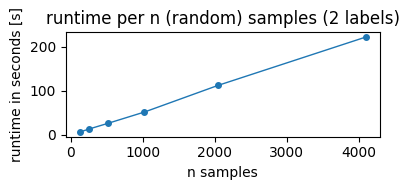

In [12]:
# by dimensionality
fig = plt.figure(figsize=(4, 2))
ax = fig.gca()

x = [r[1] for r in res]
# bws = 1 / np.array(x)

ys = np.stack([r[2][0] for r in res])
avgs = np.average(ys, 1)
mds = np.median(ys, 1)
stds = np.std(ys, 1)

ax.plot(x, avgs, linewidth=1)
ax.scatter(x, avgs, s=2**4)
# ax.scatter(x, mds, s=2**4, marker="x")
# ax.errorbar(x, avgs, yerr=stds, fmt='none')


ax.set_xlabel(r"n samples")
ax.set_ylabel("runtime in seconds [s]")

ax.set_title("runtime per n (random) samples (2 labels)")

fig.tight_layout()
fig.show()
fig.savefig("n_samples_experiments.pdf")

In [13]:
res_3

[(2, 50, array([[0.00100493, 0.01788998, 0.00599885]])),
 (3, 50, array([[2.00748444e-03, 7.40623474e-02, 2.40928006e+00]])),
 (4, 50, array([[3.99827957e-03, 1.73389196e-01, 7.00576353e+00]])),
 (5, 50, array([[1.29995346e-02, 5.84504604e-01, 2.77743468e+01]])),
 (6, 50, array([[4.39994335e-02, 3.88205433e+00, 2.32089978e+02]]))]

C:\Users\bauerrn\AppData\Local\Temp\ipykernel_31248\2301415504.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


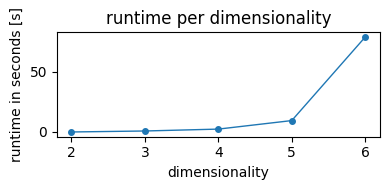

In [15]:
# by dimensionality
fig = plt.figure(figsize=(4, 2))
ax = fig.gca()

x = [r[0] for r in res_3]
# bws = 1 / np.array(x)

ys = np.stack([r[2][0] for r in res_3])
avgs = np.average(ys, 1)
mds = np.median(ys, 1)
stds = np.std(ys, 1)

ax.plot(x, avgs, linewidth=1)
ax.scatter(x, avgs, s=2**4)
# ax.scatter(x, mds, s=2**4, marker="x")
# ax.errorbar(x, avgs, yerr=stds, fmt='none')


ax.set_xlabel(r"dimensionality")
ax.set_ylabel("runtime in seconds [s]")

ax.set_title("runtime per dimensionality")

fig.tight_layout()
fig.show()
fig.savefig("n_dim_experiments.pdf")